In [1]:
import h5py
import matplotlib.pyplot as plt
import mpl_lego as mplego
import neuropacks as packs
import numpy as np
import os
import pickle

from matplotlib.collections import LineCollection
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_lego.ellipse import plot_cov_ellipse
from noise_correlations import analysis, utils 
from scipy.stats import spearmanr, ttest_1samp, binned_statistic
from settings import colors, titles, ax_label_size, tick_label_size, letter_size, legend_size

In [2]:
exp, d = "10", 20
base_path = f"/storage/noise_correlations/exp{exp}"

In [3]:
ret2_path = os.path.join(base_path, f'exp{exp}_ret2_{d}_1000_1000.h5')
pvc11_1_path = os.path.join(base_path, f'exp{exp}_1_pvc11_{d}_1000_1000.h5')
ecog_path = os.path.join(base_path, f'exp{exp}_ecog_{d}_3000_1000.h5')

In [4]:
pvc11_1 = h5py.File(pvc11_1_path, 'r')
ret2 = h5py.File(ret2_path, 'r')
ecog = h5py.File(ecog_path, 'r')
results = [ret2, pvc11_1, ecog]

In [5]:
n_results = len(results)
n_max_units = pvc11_1['units'].shape[2]
dims = 3 + np.arange(n_max_units - 2)

In [6]:
with open(os.path.join(base_path, f'exp{exp}_cdfs.pkl'), 'rb') as f:
    all_null_equiv_cdfs, all_opt_fa_equiv_cdfs, all_opt_equiv_cdfs = pickle.load(f)
# all_null_equiv_cdfs = [all_null_equiv_cdfs[3], all_null_equiv_cdfs[0], all_null_equiv_cdfs[4]]
# all_opt_fa_equiv_cdfs = [all_opt_fa_equiv_cdfs[3], all_opt_fa_equiv_cdfs[0], all_opt_fa_equiv_cdfs[4]]
# all_opt_equiv_cdfs = [all_opt_equiv_cdfs[3], all_opt_equiv_cdfs[0], all_opt_equiv_cdfs[4]]

In [7]:
# Calculate correlations between max CDFs and percentiles
fa_corrs = np.zeros((len(results), dims.size))

for result_idx, result in enumerate(results):
    for dim_idx, dim in enumerate(dims):
        fa_corrs[result_idx, dim_idx] = spearmanr(
            result['p_fa_lfi'][dim_idx],
            np.max(all_opt_fa_equiv_cdfs[result_idx][dim], axis=-1) - np.max(all_null_equiv_cdfs[result_idx][dim], axis=-1),
        ).correlation

Ttest_1sampResult(statistic=-38.18545349768293, pvalue=6.402427335631706e-18)
Ttest_1sampResult(statistic=-20.956971239741133, pvalue=1.3923154786234983e-13)
Ttest_1sampResult(statistic=-15.104865864492787, pvalue=2.7719729246680278e-11)


<Figure size 360x360 with 0 Axes>

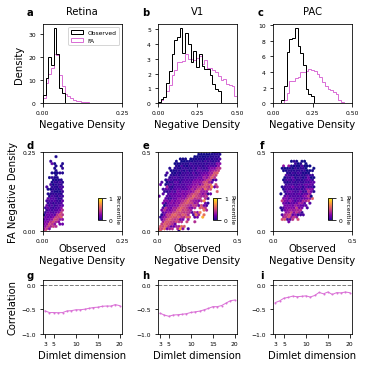

In [9]:
"""
Plot Settings
"""
result_idxs = [0, 3, 4]
dim_idx = 0
dim = dim_idx + 3

# Figure settings


# Histograms
max_cdf_bins = [
    np.linspace(0, .25, 30),
    np.linspace(0, .5, 30),
    np.linspace(0, .5, 30)]
max_cdf_hist_lw = 1
extents = [
    (0, .25, 0, .25),
    (0, .5, 0, .5),
    (0, .5, 0, .5)
]

# Hexbins
# Histogram settings
hist_lw = 1

# Hexbin settings
gridsize = 30
hex_lw = .2
norm = Normalize(vmin=0, vmax=1.)
# Font sizes
title_pad = 10

# Scatter settings
markersize = 5
compare_lw = 0.5

# Labels
model_labels = ['Observed', 'FA']
label_dict = {'observed': model_labels[0], 'fa': model_labels[1]}

# Maximum values
max_null_cdfs = [np.max(all_null_equiv_cdfs[result_idx][dim], axis=-1)
                 for result_idx in range(n_results)]
max_opt_fa_cdfs = [np.max(all_opt_fa_equiv_cdfs[result_idx][dim], axis=-1)
                   for result_idx in range(n_results)]


"""
Figure 7
"""
# Create figure
figsize = (5, 5)
fig = plt.figure(figsize=figsize)
fig = plt.figure(figsize=figsize)
le = .12
re = .021
te = .06
be = .08
rh = .15
hg = .1
w = (1. - le - re - 2.*hg) / 3.
h = w * figsize[0] / figsize[1]
vg = (1. - te - be - 2*h - rh) / 2.

axes = np.empty((3, 3), dtype=object)
caxes = np.empty(3, dtype=object)
axes[0] = [fig.add_axes([le + ii*(w + hg), be + rh + 2.*vg + h, w, h]) for ii in range(3)]
axes[1] = [fig.add_axes([le + ii*(w + hg), be + rh + 1.*vg, w, h]) for ii in range(3)]
axes[2] = [fig.add_axes([le + ii*(w + hg), be, w, rh]) for ii in range(3)]
caxes[:] = [fig.add_axes([le + ii*(w + hg) + .7*w, be + rh + vg+.03, .01, h/3.5])
            for ii in range(3)]

# Create plot, one column at a time (per dataset)
for ii, result in enumerate(results):
    # Get percentiles
    fa_percentiles = result['p_fa_lfi'][dim_idx]
    r_percentiles = result['p_r_lfi'][dim_idx]

    # Row 1: Max CDF histograms
    ax = axes[0, ii]
    ax.hist(
        [max_null_cdfs[ii],
         max_opt_fa_cdfs[ii]],
        histtype='step',
        color=[colors['observed'], colors['fa']],
        lw=max_cdf_hist_lw,
        bins=max_cdf_bins[ii],
        density=True)
    for key, label in label_dict.items():
        ax.hist([], color=colors[key], label=label, histtype='step', lw=hist_lw)
    
    # Row 2: Max CDFs vs. Percentiles
    percentiles = result['p_fa_lfi'][dim_idx]
    axes[1, ii].hexbin(
        max_null_cdfs[ii],
        max_opt_fa_cdfs[ii],
        C=percentiles,
        gridsize=gridsize,
        cmap='plasma',
        extent=extents[ii],
        norm=norm,
        linewidths=hex_lw)
    cax = caxes[ii]
    fig.colorbar(ScalarMappable(norm=norm, cmap='plasma'), cax=cax)
    cax.set_ylabel(
        r'Percentile',
        fontsize=tick_label_size,
        rotation=270,
        labelpad=7)
    cax.tick_params(labelsize=tick_label_size)

    # Row 3: Correlation comparisons
    ax = axes[2, ii]
    ax.plot(
        dims,
        fa_corrs[ii],
        color=colors['fa'],
        marker='o',
        lw=1,
        markersize=1,
        zorder=1000)
    print(ttest_1samp(fa_corrs[ii], 0.))


# Axis ticks, labels, and additional settings
axes[0, 0].set_title('Retina', fontsize=ax_label_size, pad=title_pad)
axes[0, 1].set_title('V1', fontsize=ax_label_size, pad=title_pad)
axes[0, 2].set_title('PAC', fontsize=ax_label_size, pad=title_pad)

for ax in axes[0]:
    ax.set_xticks([0, 0.25, .5])
    ax.set_xlabel('Negative Density', fontsize=ax_label_size)
    ax.tick_params(labelsize=tick_label_size)
    ax.set_xlim(0, .5)
axes[0, 0].legend(
        loc='best',
        prop={'size': legend_size})
axes[0, 0].set_ylabel('Density', fontsize=ax_label_size)
axes[0, 0].set_xticks([0, 0.25])
axes[0, 0].set_xlim(0, .25)

for ax in axes[1]:
    ax.set_xlim([0.0, .5])
    ax.set_ylim([0.0, .5])
    ax.set_xticks([0, 0.5])
    ax.set_yticks([0, 0.5])
    ax.set_xlabel('Observed\nNegative Density', fontsize=ax_label_size, labelpad=0)
axes[1, 0].set_ylabel('FA Negative Density', fontsize=ax_label_size)
axes[1, 0].set_xlim([0.0, .25])
axes[1, 0].set_ylim([0.0, .25])
axes[1, 0].set_xticks([0, 0.25])
axes[1, 0].set_yticks([0, 0.25])

for ax in axes[-1]:
    ax.set_xlim([2.5, max(dims) + 0.5])
    ax.set_ylim([-1, 0.1])
    ax.set_xticks([3, 5, 10, 15, 20])
    ax.set_yticks([-1, -0.5, 0])
    ax.set_xlabel(r'Dimlet dimension', fontsize=ax_label_size)
    ax.axhline(0, color='gray', linestyle='--', lw=1)
axes[-1, 0].set_ylabel(r'Correlation', fontsize=ax_label_size)

# Apply subplot labels
lets = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n']
ii = 0
for y in [.96, .59, .23]:
    for x in [le + ii*(hg + w) - .025 for ii in range(3)]:
        fig.text(x, y, lets[ii], size=letter_size, fontweight='bold',
                 ha='right', va='bottom')
        ii += 1


for ax in axes.ravel():
    ax.tick_params(labelsize=tick_label_size)

plt.tight_layout()
plt.savefig('figure6.pdf', dpi=300)
plt.savefig('figure6.jpg', dpi=300)
plt.show()